<a href="https://colab.research.google.com/github/ZeyadSabbah/TrivagoRecommenderSystem/blob/master/ModelingParVal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Selection & Modeling
## Mounting to Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/My Drive/Trivago/Project/TrivagoRecommenderSystem

/content/drive/My Drive/Trivago/Project/TrivagoRecommenderSystem


## Loading Libraries & Datasets

In [0]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from datetime import datetime
import random
import joblib
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
TrainDataFilepath = './Datasets/clean_data/Sets/train.csv'
TrainData = pd.read_csv(TrainDataFilepath)

# declaring features and label
features = TrainData.drop(columns=['session_id', 'item_id', 'clickout']).columns.tolist()
label = ['clickout']

## Features Correlation

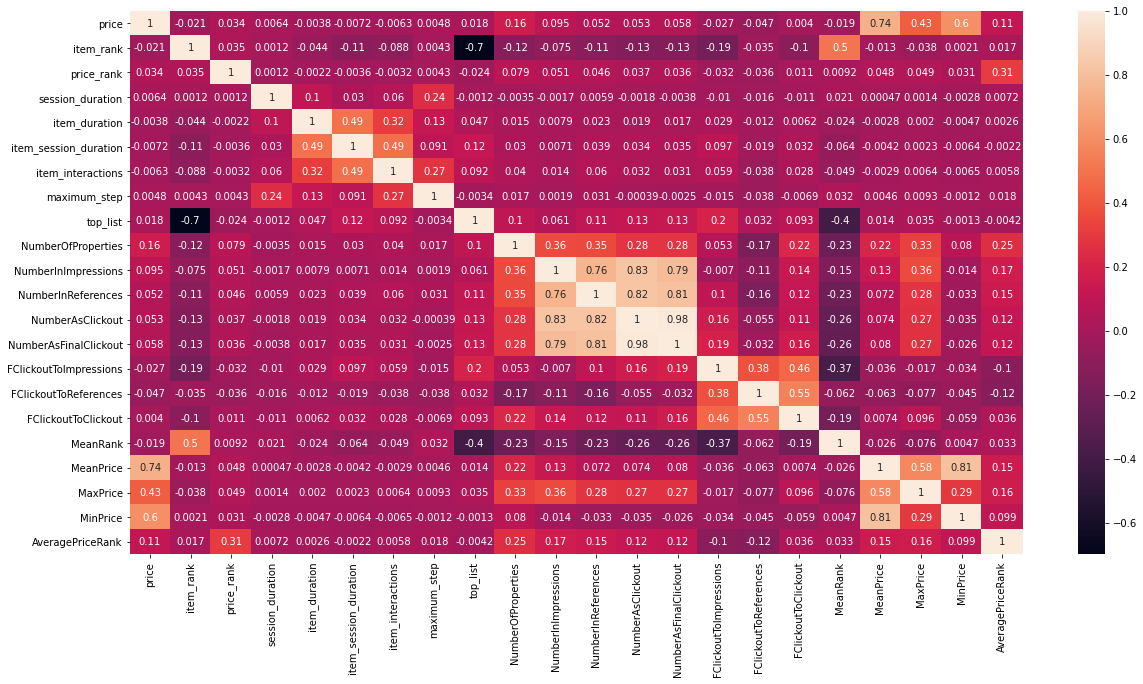

In [0]:
CorrMatrix = TrainData[features].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(CorrMatrix, annot=True)
plt.show()

* item_rank has a strong negative correlation with top_list, that's normal since it is treated as continous variable while it should be treated as a nominal value of wether or not the item is on top of the list already.  
* NumberInImpressions & NumberInReferences have strong correlations with each other's, and also with NumberAsClickout. So, they should be dropped.
*MeanPrice and MinPrice have strong correlations with Price, so they need to be dropped as well.

In [0]:
FeaturesToDrop = ['NumberInImpressions', 'NumberInReferences', 'MeanPrice', 'MinPrice']
for feature in FeaturesToDrop:
  features.remove(feature)

X_train = TrainData[features]
y_train = TrainData[label]

## SelectKBest

In [0]:
bestfeatures = SelectKBest(score_func=chi2, k=8)
fit = bestfeatures.fit(X_train, y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']  #naming the dataframe columns
print(featureScores.nlargest(8,'Score'))   #print 8 best features

                    Specs         Score
4           item_duration  2.840552e+08
6       item_interactions  1.272761e+07
10       NumberAsClickout  3.023488e+06
11  NumberAsFinalClickout  2.303099e+06
1               item_rank  2.095303e+06
0                   price  6.917975e+05
5   item_session_duration  6.014721e+05
8                top_list  5.040456e+05


Scores are high which means the features are relevant to the output, so all of the features will be taken in modeling at first, and then by removing the least important features, the performance of the model will be captured.

In [0]:
features = featureScores.nlargest(8,'Score').Specs.tolist()
X_train = TrainData[features]
y_train = TrainData[label]

TrainData is ready for processing and modeling, while validation and test sets still need to be engineered. There is a ready function that will transform sets into the same form of TrainData.

## Scaling Features

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('std_scaler', StandardScaler()),
])

from sklearn.compose import ColumnTransformer
full_pipeline = ColumnTransformer([
("num", num_pipeline, list(X_train[features])) #One little mistake I made, but would not differ is that I standardized the top_list, it is
])                                             #a categorical feature and should not be standardized.

X_train_scaled = full_pipeline.fit_transform(X_train)

## Models

###Without Resampling

#### Logistic Regression

In [0]:
C_list = [0.001, 0.01, 0.1, 1, 10]

for C in C_list:
  lr = LogisticRegression(C=C, n_jobs=-1)
  lr.fit(X_train_scaled, y_train.clickout.values.ravel())
  joblib.dump(lr, './modelsNew/LR_modelC{}.pkl'.format(C))

#### Random Forest

In [0]:
n_estimators = [50, 100, 150, 200]
max_depth = [1, 3, 5]

for depth in max_depth:
  for n_estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=n_estimator, max_depth=depth, max_features=3, n_jobs=-1)
    rf.fit(X_train_scaled, y_train.clickout.values.ravel())
    joblib.dump(rf, './modelsNew/RF_modelDepth{}N{}.pkl'.format(depth, n_estimator))
    print('Depth {} and N Estimator {} is done.'.format(depth, n_estimator))

Depth 1 and N Estimator 50 is done.
Depth 1 and N Estimator 100 is done.
Depth 1 and N Estimator 150 is done.
Depth 1 and N Estimator 200 is done.
Depth 3 and N Estimator 50 is done.
Depth 3 and N Estimator 100 is done.
Depth 3 and N Estimator 150 is done.
Depth 3 and N Estimator 200 is done.
Depth 5 and N Estimator 50 is done.
Depth 5 and N Estimator 100 is done.
Depth 5 and N Estimator 150 is done.
Depth 5 and N Estimator 200 is done.


#### XGBoost

In [0]:
n_estimators = [50, 100, 150, 200]
max_depth = [1, 3, 5]
learning_rate = [0.01, 0.1, 1]

for depth in max_depth:
  for l_rate in learning_rate:
    for n_estimator in n_estimators:
      gb = GradientBoostingClassifier(n_estimators=n_estimator, max_depth=depth, learning_rate=l_rate, max_features=3)
      gb.fit(X_train_scaled, y_train.clickout.values.ravel())
      joblib.dump(gb, './modelsNew/XGB_modelDepth{}N{}Lrate{}.pkl'.format(depth, n_estimator, l_rate))
      print('Depth {}, N Estimator {}, and Lrate {} is done.'.format(depth, n_estimator, l_rate))

Depth 5, N Estimator 50, and Lrate 0.01 is done.
Depth 5, N Estimator 100, and Lrate 0.01 is done.
Depth 5, N Estimator 150, and Lrate 0.01 is done.
Depth 5, N Estimator 200, and Lrate 0.01 is done.
Depth 5, N Estimator 50, and Lrate 0.1 is done.
Depth 5, N Estimator 100, and Lrate 0.1 is done.
Depth 5, N Estimator 150, and Lrate 0.1 is done.
Depth 5, N Estimator 200, and Lrate 0.1 is done.
Depth 5, N Estimator 50, and Lrate 1 is done.
Depth 5, N Estimator 100, and Lrate 1 is done.
Depth 5, N Estimator 150, and Lrate 1 is done.
Depth 5, N Estimator 200, and Lrate 1 is done.


### With SMOTE

In [0]:
t1 = datetime.now()
sm = SMOTE(ratio=0.5, random_state=0, n_jobs=-1)
X_SM, y_SM = sm.fit_sample(X_train_scaled, y_train)
t2 = datetime.now()
print('Time taken:', t2 - t1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Time taken: 0:09:15.774562


#### Logistic Regression

In [0]:
C_list = [0.001, 0.01, 0.1, 1, 10]

for C in C_list:
  lr = LogisticRegression(C=C, n_jobs=-1)
  lr.fit(X_SM, y_SM)
  joblib.dump(lr, './modelsNew/LR_ SMOTE_C{}.pkl'.format(C))

#### Random Forest

In [0]:
n_estimators = [50, 100, 150, 200]
max_depth = [1, 3, 5]

for depth in max_depth:
  for n_estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=n_estimator, max_depth=depth, max_features=3, n_jobs=-1)
    rf.fit(X_SM, y_SM)
    joblib.dump(rf, './modelsNew/RF_SMOTEDepth{}N{}.pkl'.format(depth, n_estimator))
    print('Depth {} and N Estimator {} is done.'.format(depth, n_estimator))

Depth 1 and N Estimator 50 is done.
Depth 1 and N Estimator 100 is done.
Depth 1 and N Estimator 150 is done.
Depth 1 and N Estimator 200 is done.
Depth 3 and N Estimator 50 is done.
Depth 3 and N Estimator 100 is done.
Depth 3 and N Estimator 150 is done.
Depth 3 and N Estimator 200 is done.
Depth 5 and N Estimator 50 is done.
Depth 5 and N Estimator 100 is done.
Depth 5 and N Estimator 150 is done.
Depth 5 and N Estimator 200 is done.


#### XGBoost

In [0]:
n_estimators = [50, 100, 150, 200]
max_depth = [1, 3, 5]
learning_rate = [0.01, 0.1]

for depth in max_depth:
  for l_rate in learning_rate:
    for n_estimator in n_estimators:
      gb = GradientBoostingClassifier(n_estimators=n_estimator, max_depth=depth, learning_rate=l_rate, max_features=3)
      gb.fit(X_train_scaled, y_train.clickout.values.ravel())
      joblib.dump(gb, './modelsNew/XGB_SMOTEDepth{}N{}Lrate{}.pkl'.format(depth, n_estimator, l_rate))
      print('Depth {}, N Estimator {}, and Lrate {} is done.'.format(depth, n_estimator, l_rate))

Depth 3, N Estimator 50, and Lrate 0.01 is done.
Depth 3, N Estimator 100, and Lrate 0.01 is done.
Depth 3, N Estimator 150, and Lrate 0.01 is done.
Depth 3, N Estimator 200, and Lrate 0.01 is done.
Depth 3, N Estimator 50, and Lrate 0.1 is done.
Depth 3, N Estimator 100, and Lrate 0.1 is done.
Depth 3, N Estimator 150, and Lrate 0.1 is done.
Depth 3, N Estimator 200, and Lrate 0.1 is done.
Depth 5, N Estimator 50, and Lrate 0.01 is done.
Depth 5, N Estimator 100, and Lrate 0.01 is done.
Depth 5, N Estimator 150, and Lrate 0.01 is done.
Depth 5, N Estimator 200, and Lrate 0.01 is done.
Depth 5, N Estimator 50, and Lrate 0.1 is done.
Depth 5, N Estimator 100, and Lrate 0.1 is done.
Depth 5, N Estimator 150, and Lrate 0.1 is done.
Depth 5, N Estimator 200, and Lrate 0.1 is done.


### With Undersampling

In [0]:
from imblearn.under_sampling import NearMiss

nm = NearMiss(version=1, n_neighbors=3, random_state=0, n_jobs=-1)
X_usample, y_usample = nm.fit_resample(X_train_scaled, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Logistic Regression

In [0]:
C_list = [0.001, 0.01, 0.1, 1, 10]

for C in C_list:
  lr = LogisticRegression(C=C, n_jobs=-1)
  lr.fit(X_usample, y_usample)
  joblib.dump(lr, './modelsNew/LR_Usample_C{}.pkl'.format(C))

#### Random Forest

In [0]:
n_estimators = [50, 100, 150, 200]
max_depth = [1, 3, 5]

for depth in max_depth:
  for n_estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=n_estimator, max_depth=depth, max_features=3, n_jobs=-1)
    rf.fit(X_usample, y_usample)
    joblib.dump(rf, './modelsNew/RF_UsampleDepth{}N{}.pkl'.format(depth, n_estimator))
    print('Depth {} and N Estimator {} is done.'.format(depth, n_estimator))

Depth 1 and N Estimator 50 is done.
Depth 1 and N Estimator 100 is done.
Depth 1 and N Estimator 150 is done.
Depth 1 and N Estimator 200 is done.
Depth 3 and N Estimator 50 is done.
Depth 3 and N Estimator 100 is done.
Depth 3 and N Estimator 150 is done.
Depth 3 and N Estimator 200 is done.
Depth 5 and N Estimator 50 is done.
Depth 5 and N Estimator 100 is done.
Depth 5 and N Estimator 150 is done.
Depth 5 and N Estimator 200 is done.


#### XGBoost

In [0]:
n_estimators = [50, 100, 150, 200]
max_depth = [1, 3, 5]
learning_rate = [0.01, 0.1, 1]

for depth in max_depth:
  for l_rate in learning_rate:
    for n_estimator in n_estimators:
      gb = GradientBoostingClassifier(n_estimators=n_estimator, max_depth=depth, learning_rate=l_rate, max_features=3)
      gb.fit(X_usample, y_usample)
      joblib.dump(gb, './modelsNew/XGB_UsampleDepth{}N{}Lrate{}.pkl'.format(depth, n_estimator, l_rate))
      print('Depth {}, N Estimator {}, and Lrate {} is done.'.format(depth, n_estimator, l_rate))

Depth 1, N Estimator 50, and Lrate 0.01 is done.
Depth 1, N Estimator 100, and Lrate 0.01 is done.
Depth 1, N Estimator 150, and Lrate 0.01 is done.
Depth 1, N Estimator 200, and Lrate 0.01 is done.
Depth 1, N Estimator 50, and Lrate 0.1 is done.
Depth 1, N Estimator 100, and Lrate 0.1 is done.
Depth 1, N Estimator 150, and Lrate 0.1 is done.
Depth 1, N Estimator 200, and Lrate 0.1 is done.
Depth 1, N Estimator 50, and Lrate 1 is done.
Depth 1, N Estimator 100, and Lrate 1 is done.
Depth 1, N Estimator 150, and Lrate 1 is done.
Depth 1, N Estimator 200, and Lrate 1 is done.
Depth 3, N Estimator 50, and Lrate 0.01 is done.
Depth 3, N Estimator 100, and Lrate 0.01 is done.
Depth 3, N Estimator 150, and Lrate 0.01 is done.
Depth 3, N Estimator 200, and Lrate 0.01 is done.
Depth 3, N Estimator 50, and Lrate 0.1 is done.
Depth 3, N Estimator 100, and Lrate 0.1 is done.
Depth 3, N Estimator 150, and Lrate 0.1 is done.
Depth 3, N Estimator 200, and Lrate 0.1 is done.
Depth 3, N Estimator 50, 